This project aims to utilize telco customer's demographic data and account information to predict if they will continue subscribing the service or not with the dataset “TelcoChurnData.csv”, which the churn data is stored as Churn (Yes = leave; No = stay).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report

### Get Data

In [2]:
df = pd.read_csv('TelcoChurnData.csv')
df.sample(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6644,0898-XCGTF,Male,0,Yes,No,61,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic),96.5,5673.7,No


In [3]:
df.shape

(7043, 21)

### Data Cleaning

In [4]:
df.drop('customerID', axis=1, inplace=True)

In [5]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We need to convert the object columns to numeric for our model.

In [6]:
df0 = df.copy()
for col in df0.columns:
    df0[col].replace('No phone service', 'No', inplace=True)
    df0[col].replace('No internet service', 'No', inplace=True)
    df0[col].replace({'Male': 0, 'Female': 1}, inplace=True)
    df0[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    if df0[col].dtypes == 'object':
        print(col, ':', df0[col].unique())

InternetService : ['DSL' 'Fiber optic' 0]
Contract : ['Month-to-month' 'One year' 'Two year']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


In [7]:
df1 = pd.get_dummies(data=df0, columns=['InternetService', 'Contract', 'PaymentMethod'])

In [8]:
df1.shape

(7043, 27)

In [9]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges, errors='coerce')

In [10]:
df1.isnull().sum()

gender                                      0
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
MultipleLines                               0
OnlineSecurity                              0
OnlineBackup                                0
DeviceProtection                            0
TechSupport                                 0
StreamingTV                                 0
StreamingMovies                             0
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                               11
Churn                                       0
InternetService_0                           0
InternetService_DSL                         0
InternetService_Fiber optic                 0
Contract_Month-to-month                     0
Contract_One year                 

The dataset quality is quite good, except there are some missing values in the TotalCharges column. Hence, we would like to use KNN to fill in those blank spaces.

### Fill in TotalCharges missing value with KNN

Data normalization will be first conducted before filling in the missing values with KNN.

In [11]:
for col in df1.columns:
    print(col, ':', df1[col].unique())

gender : [1 0]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
TechSupport : [0 1]
StreamingTV : [0 1]
StreamingMovies : [0 1]
PaperlessBilling : [1 0]
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : [0 1]
InternetService_0 : [0 1]
InternetService_DSL : [1 0]
InternetService_Fiber optic : [0 1]
Contract_Month-to-month : [1 0]
Contract_One year : [0 1]
Contract_Two year : [0 1]
PaymentMethod_Bank transfer (automatic) : [0 1]
PaymentMethod_Credit card (automatic) : [0 1]
PaymentMethod_Electronic check : [1 0]
PaymentMethod_Mailed check : [0 1]


In [12]:
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])
df1[cols_to_scale].head(1)

,tenure,MonthlyCharges,TotalCharges
0,0.013889,0.115423,0.001275


In [13]:
knn = KNNImputer(n_neighbors=5)
knn.fit_transform(df1)

array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
df2 = pd.DataFrame(knn.fit_transform(df1), columns=df1.columns)
df2.loc[df2.TotalCharges.isnull()].shape

(0, 27)

### ML Data Preparation

In [15]:
X = df2.drop('Churn', axis=1)

In [16]:
y = df2.Churn

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [18]:
X_train.shape

(5634, 26)

In [19]:
X_test.shape

(1409, 26)

### Random Forest Resampled

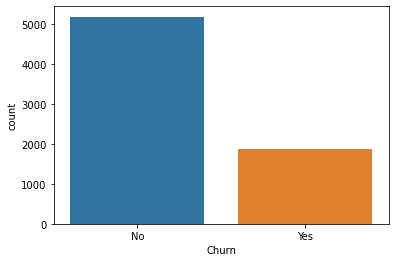

In [20]:
sns.countplot(data=df, x="Churn")
plt.xticks([0.0, 1.0], ['No', 'Yes'])
plt.show()

There is a class imbalance problem in the dataset, which Churn = Yes is less than half of Churn = No.
We will then use SMOTE to overcome the class imbalance issue.

In [21]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(X, y)

In [22]:
X_train_resample, X_test_resample, y_train_resample, y_test_resample = train_test_split(X_resample, y_resample, test_size=0.2, random_state=5)

In [23]:
model = RandomForestClassifier(criterion='gini', random_state=100, max_depth=6, min_samples_leaf=8)
model.fit(X_train_resample, y_train_resample)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [24]:
y_pred_resample = model.predict(X_test_resample)

In [25]:
model.score(X_test_resample, y_test_resample)

0.920926517571885

In [26]:
print(classification_report(y_test_resample, y_pred_resample, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       540
           1       0.92      0.95      0.93       712

    accuracy                           0.92      1252
   macro avg       0.92      0.92      0.92      1252
weighted avg       0.92      0.92      0.92      1252



In [27]:
print(confusion_matrix(y_test_resample, y_pred_resample))

[[480  60]
 [ 39 673]]


### Corresponding importance of the variables in the model

In [28]:
feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
feature_scores

MultipleLines                              0.001353
PaymentMethod_Bank transfer (automatic)    0.001960
PaymentMethod_Credit card (automatic)      0.002037
DeviceProtection                           0.002496
PhoneService                               0.003416
gender                                     0.003513
SeniorCitizen                              0.003908
PaymentMethod_Mailed check                 0.003985
Partner                                    0.006479
OnlineBackup                               0.007359
Dependents                                 0.007861
StreamingMovies                            0.008629
StreamingTV                                0.008747
OnlineSecurity                             0.011460
InternetService_DSL                        0.017306
TechSupport                                0.024294
PaperlessBilling                           0.025353
Contract_One year                          0.026674
TotalCharges                               0.034622
InternetServ

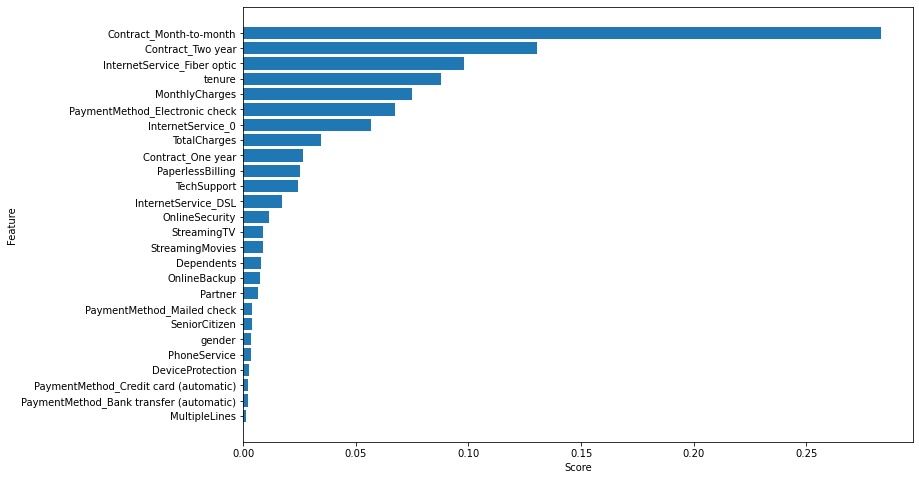

In [29]:
plt.figure(figsize=(12, 8))
plt.barh(feature_scores.index, feature_scores)
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

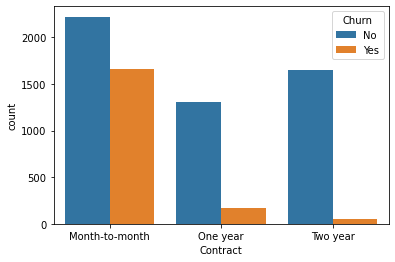

In [30]:
sns.countplot(data=df, x="Contract", hue="Churn")
plt.show()

According to the feature scores, variable Contract_month-to-month and Contract_Two year are the most influential factors to the churn rate. As shown in the graph above, the number of Churn = Yes drops drastically from month-to-month contract to a two year contract, meaning the churn rate is also much lower when the contract length longer. This is reasonable as the longer the contract, users have smaller flexibility to switch their plans. Afterwards, when they are used to the current service, they then have smaller incentive to switch to something new. As a result, most of them will stay.

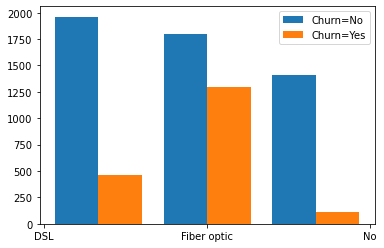

In [31]:
a = df[df.Churn == 'No'].InternetService
b = df[df.Churn == 'Yes'].InternetService
plt.hist([a, b], label=['Churn=No', 'Churn=Yes'], bins=3)
plt.legend()
plt.show()

The above chart also shows that among all internet service providers, there are more customers leaving if they are using Fiber optic, comparing to DSL and some other provider.

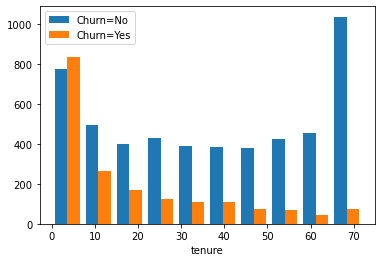

In [32]:
tenure_churn_no = df[df.Churn == 'No'].tenure
tenure_churn_yes = df[df.Churn == 'Yes'].tenure
plt.hist([tenure_churn_no, tenure_churn_yes], label=['Churn=No', 'Churn=Yes'])
plt.xlabel('tenure')
plt.legend()
plt.show()

Tenure, being the 4th most influential variable, it is obvious that among the customers with less than 10 months tenure, the churn rate is the highest. When the tenure gets longer, the number of customers who are leaving decreases constantly. Most importantly, when the tenure reaches around 70 months, the churn rate is extremely low. With all of the statistics, the company should first provide more incentives to attract customers to join plans that are over 10 months long to greatly increase their chance to retain in the company.

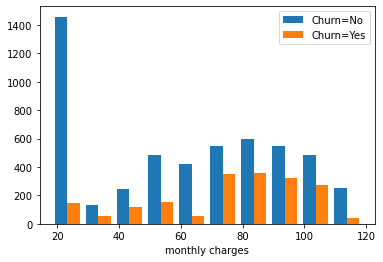

In [34]:
MonthlyCharges_churn_no = df[df.Churn == 'No'].MonthlyCharges
MonthlyCharges_churn_yes = df[df.Churn == 'Yes'].MonthlyCharges
plt.hist([MonthlyCharges_churn_no, MonthlyCharges_churn_yes], label=['Churn=No', 'Churn=Yes'])
plt.xlabel('monthly charges')
plt.legend()
plt.show()

Monthly charges is also an important variable in this prediction model. From the graph above, it is clear that when the monthly fee is as low as \\$20, the churn rate will be extremely low. However, even when the monthly charges increases to \\$60, the number of leaving customers are still less than half of the number of customers who stay. Therefore, having a smart pricing strategy is also important for the company to maximize its profit.